In [1]:
import scvi
import scanpy as sc
import pandas as pd
import numpy as np

Global seed set to 0


In [2]:
import matplotlib.pyplot as plt

In [3]:
import scanpy.external as sce

In [4]:
import torch
import pickle

In [5]:
import anndata

In [6]:
import h5py

In [7]:
import os

In [8]:
from pyscenic.aucell import aucell
from pyscenic.genesig import GeneSignature
from pyscenic.aucell import create_rankings, enrichment

#### Load data

In [12]:
adata = sc.read('siletti_non_neuronal_cells.h5ad')

In [70]:
adata.var.index = adata.var['Gene']

In [17]:
adata_immune = adata[adata.obs['cluster_id'].isin([0,1,2,3])].copy()

In [20]:
import celltypist

In [21]:
adata_celltypist = adata_immune.copy()

In [22]:
sc.pp.normalize_total(adata_celltypist, target_sum=1e4)
sc.pp.log1p(adata_celltypist)

In [23]:
model = celltypist.models.Model.load(model = 'Immune_All_Low.pkl')

In [25]:
predictions = celltypist.annotate(adata_celltypist, model = 'Immune_All_Low.pkl', majority_voting = True)#, mode = 'prob match')

🔬 Input data has 3753 cells and 14406 genes
🔗 Matching reference genes in the model
🧬 3953 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [26]:
adata_immune.obs['celltypist_prediction'] = predictions.predicted_labels['predicted_labels'][adata_immune.obs.index]#.to_numpy()
adata_immune.obs['celltypist_majority_voting'] = predictions.predicted_labels['majority_voting'][adata_immune.obs.index]#.to_numpy()

In [27]:
adata_immune[adata_immune.obs['cluster_id'] == 2]

View of AnnData object with n_obs × n_vars = 671 × 14406
    obs: 'BadCells', 'Paris21', 'PunchcardClusters', 'Split', 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'celltypist_prediction', 'celltypist_majority_voting'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'batch_condition', 'schema_version', 'title'
    obsm: 'X_UMAP', 'X_tSNE'

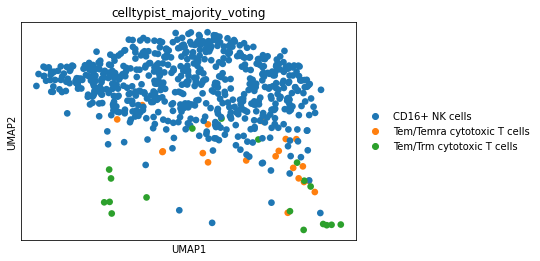

In [29]:
sc.pl.embedding(adata_immune[adata_immune.obs['cluster_id'] == 2], basis='UMAP', color='celltypist_majority_voting')

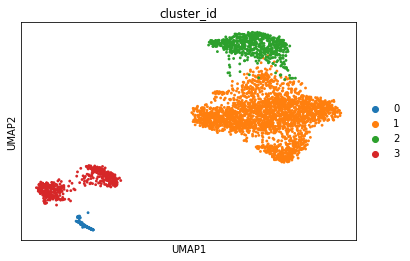

In [30]:
sc.pl.embedding(adata_immune, basis='UMAP', color='cluster_id')

#### QC

In [32]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL")) # annotate ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True) #qc_vars=['mt', 'ribo']

In [34]:
adata = adata[adata.obs.total_counts > 300, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.total_counts < 40000, :]

#### Train model

In [31]:
scvi.model.SCVI.setup_anndata(adata_immune, batch_key="donor_id")

Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [32]:
vae = scvi.model.SCVI(adata_immune, n_layers=2, n_latent=30, gene_likelihood="nb")

In [33]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|██████████| 400/400 [07:45<00:00,  1.24s/it, loss=3.12e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [07:45<00:00,  1.16s/it, loss=3.12e+03, v_num=1]


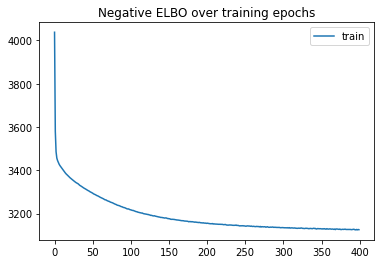

In [34]:
plt.plot(vae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [36]:
adata_immune.obsm["X_scVI"] = vae.get_latent_representation(adata_immune)

In [37]:
sc.pp.neighbors(adata_immune, use_rep="X_scVI")
sc.tl.umap(adata_immune)

In [38]:
scvi_path = 'models/brain_normal_immune_cells_scvi'
vae.save(scvi_path, overwrite=True)

In [41]:
sc.tl.leiden(adata_immune, resolution=2)

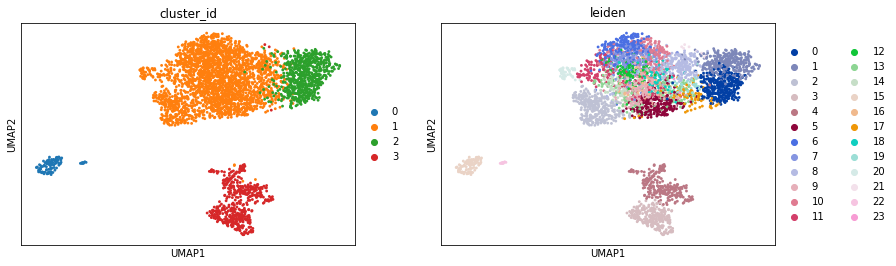

In [42]:
sc.pl.umap(adata_immune, color=['cluster_id', 'leiden'])

In [36]:
adata_nk = adata_immune[adata_immune.obs['cluster_id'] == 2].copy()

In [41]:
adata_nk = adata_nk[adata_nk.obs['celltypist_majority_voting'] == 'CD16+ NK cells'].copy()